# Scenario A - Noise Level Variation (individual dataset)

This file is used to zoom in and experiment on on a previously generated dataset.

The model used in the inference of the parameters is formulated as follows: 

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + \epsilon
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local utility functions

In [2]:
import datetime
import os
import sys
sys.path.append('../../utils')
import utils as utl
import datagen as dg
import models as mdl
import results as res
import figures as fig

## Local settings

In [3]:
# dataset to load
ndata = '06'
input_datafile = './input_datasets/dataset_'+ str(ndata) + '.csv' 
input_peakfile = './input_datasets/peakinfo.csv' 

# output for results and images
out_path = './output_' + str(ndata) + '/'
fbase    = 'scenario_noise' + str(ndata)
file_basename = out_path + fbase

# if dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

# initialization method for sampler ('jitter+adapt_diag'/'advi+adapt_diag'/'adapt_diag')
init_mode = 'adapt_diag'
    
# provide peak positions to the model as testvalues ('yes'/'no')
peak_info = 'yes'

# model mode ('train')
model_mode = 'train'

# number of times to run inference engine on dataset
niter = 4

# number of cores to run
ncores = 2

# number of samples per chain
nsamples = 2000

## Save configuration

In [4]:
fp = open(out_path + 'settings.txt', 'w')
fp.write('start : ' + datetime.datetime.now().strftime("%A, %d. %B %Y %I:%M%p") + '\n')
fp.write('input file = ' + input_datafile + '\n')
fp.write('init_mode  = ' + init_mode + '\n')
fp.write('peak_info  = ' + peak_info + '\n')
fp.write('ncores     = ' + str(ncores) + '\n')
fp.write('nsamples   = ' + str(nsamples) + '\n')
fp.close()

# Load data and plot

In [5]:
ldata  = []
lpeaks = []

# load data from disk
print("loading file {0}".format(input_datafile))
df = pd.read_csv(input_datafile)
ldata.append(df)
print("loading peakinfo {0}".format(input_peakfile))
pks = np.loadtxt(input_peakfile, delimiter=',')
lpeaks.append(pks[int(ndata)-1])

loading file ./input_datasets/dataset_06.csv
loading peakinfo ./input_datasets/peakinfo.csv


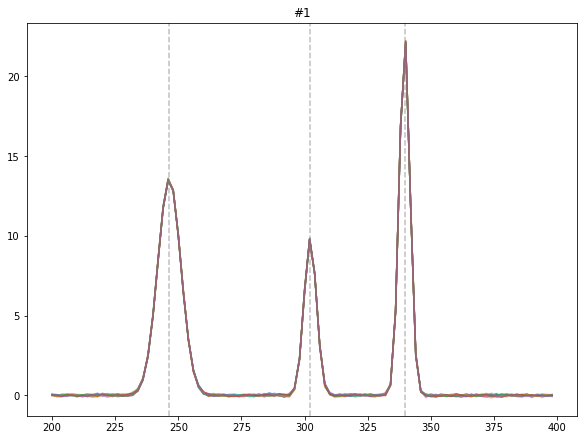

In [6]:
# plot datasets
fig.plot_datasets(ldata, lpeaks, dims=(1,1), figure_size=(8,6), savefig='yes', fname=file_basename)

# Initialize models and run inference

In [7]:
# expand dataframe and peak list
for i in range(niter-1):
    ldata.append(ldata[0])
    lpeaks.append(lpeaks[0])
    
# convert pandas data to numpy arrays
x_val = np.array(ldata[0].columns.to_list(), dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [8]:
# initialize models and run inference
models = []
traces = []

for i in range(len(ldata)):
        if peak_info == 'yes':
            plist = lpeaks[i].flatten()
            plist.sort()
            model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=3, 
                                      mu_peaks=plist, pmodel='lognormal')
        else:
            model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=3,
                                      pmodel='lognormal') 
        models.append(model_g)

        with model_g:
            if model_mode == 'train':
                print("running inference on dataset #{0}/{1}".format(i+1,len(ldata)))
                trace_g = pm.sample(nsamples, init=init_mode, cores=ncores)
                traces.append(trace_g)
                # save inference results
                pm.backends.text.dump(out_path + '/traces_%02d' % (i+1), trace_g)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #1/4


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 364.64draws/s]
The acceptance probability does not match the target. It is 0.8998747236510943, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9197950300057846, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #2/4


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 418.53draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.913996735984608, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8889869507642515, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #3/4


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 7 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 338.83draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8900766753064189, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #4/4


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 9 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 399.14draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8969273009633809, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


# Model visualization

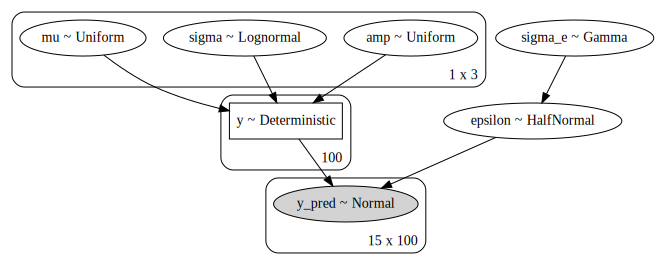

In [9]:
pm.model_to_graphviz(models[0])

In [10]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [11]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/ppsda/venv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 550.15it/s]
/home/ppsda/venv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 514.60it/s]


In [12]:
# various plots to inspect the inference results
varnames = ['amp', 'mu', 'sigma', 'epsilon']

#az.summary(traces[0], varnames)
#az.plot_trace(traces[2], varnames, compact=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[0], varnames);
#az.plot_posterior(traces[2], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

In [13]:
#az.plot_trace(traces[0], varnames, compact=True);

In [14]:
if model_mode == 'train':
    # collect the results and display
    df = res.get_results_summary(varnames, traces, ppc, y_val)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
df

/home/ppsda/venv/ppsda/lib/python3.6/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,r_hat,mcse,ess,bfmi,r2,waic,epsilon
1,1.0,0.0,4687.6,1.075175,0.999763,-4081.772381,0.061790
2,1.0,0.0,5110.3,1.014339,0.999762,-4081.297098,0.061787
3,1.0,0.0,5446.1,1.008675,0.999762,-4081.470862,0.061795
4,1.0,0.0,5704.6,1.040480,0.999762,-4081.707358,0.061795


In [15]:
if model_mode == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

# Plot posterior

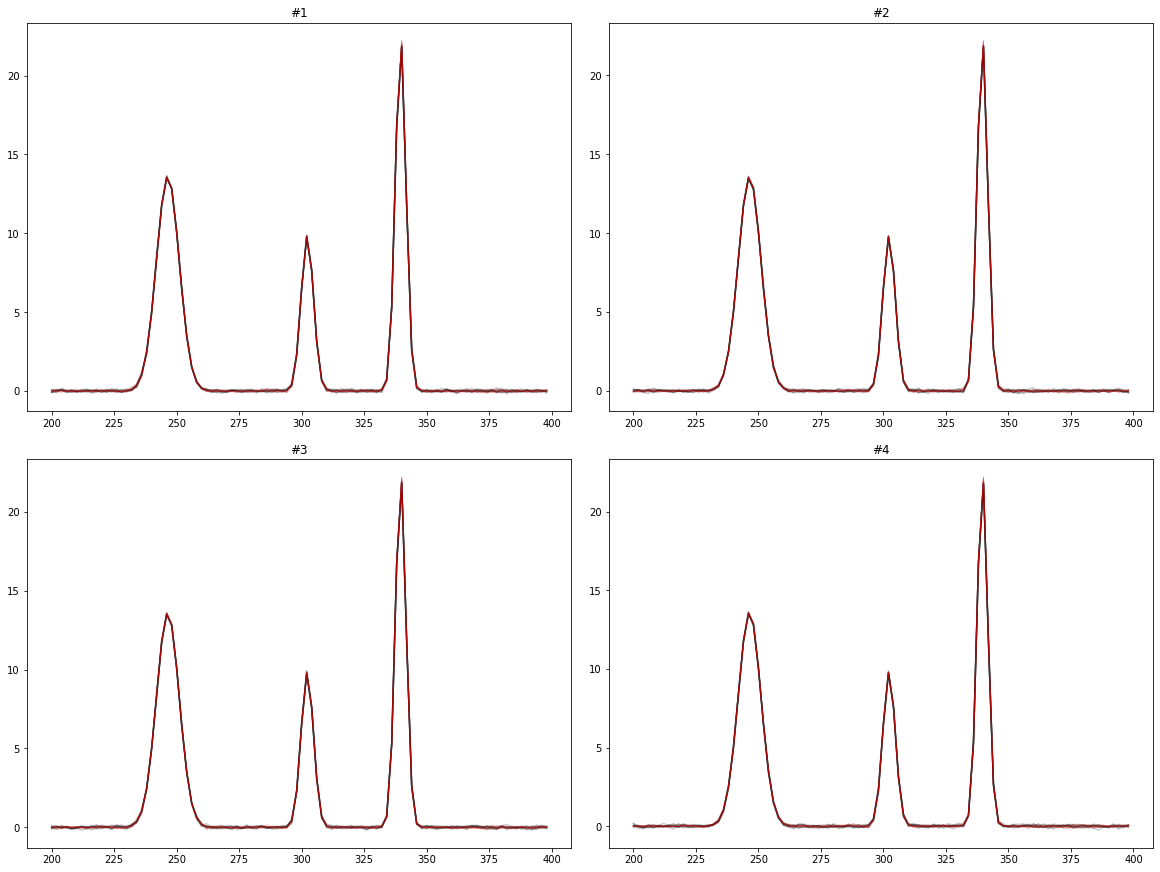

In [16]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(niter/2),2), figure_size=(16,12), savefig='yes', 
                       fname=file_basename, showpeaks='no')

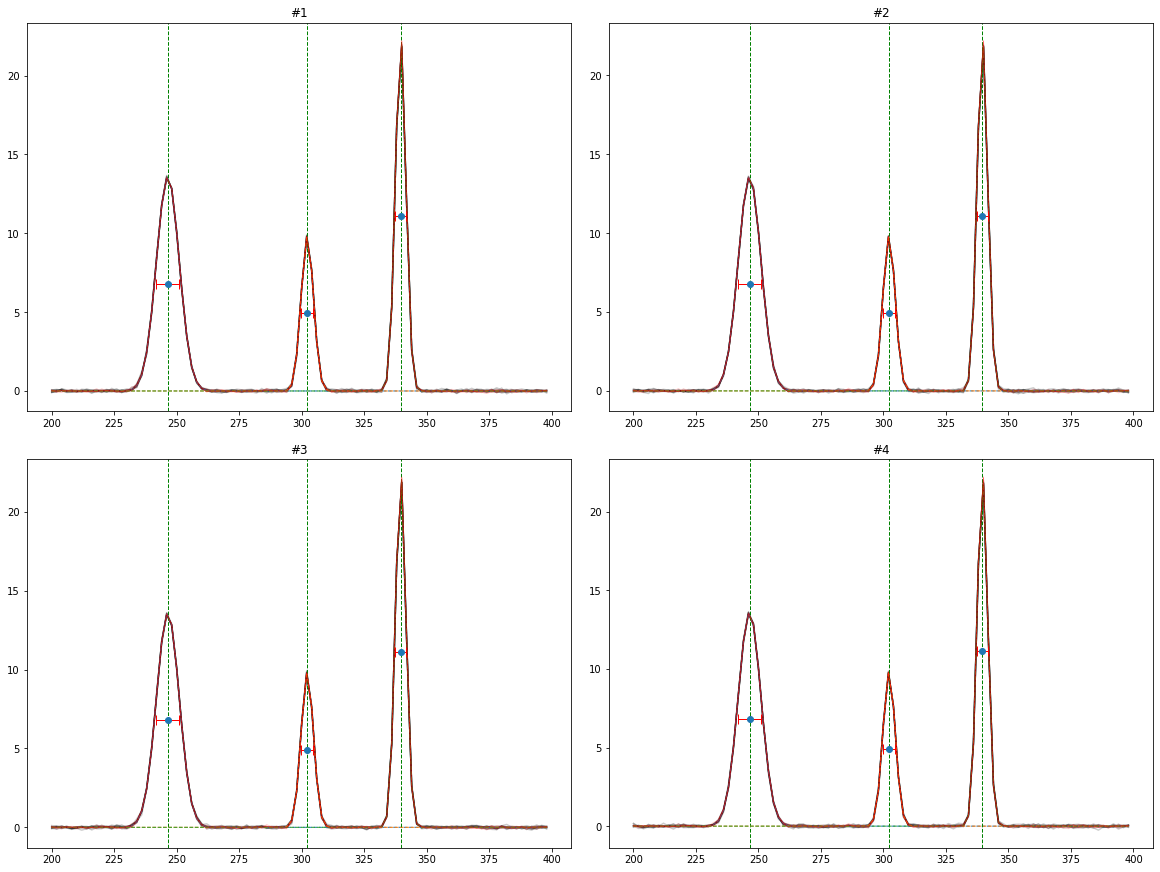

In [17]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(niter/2),2), figure_size=(16,12), savefig='yes', 
                       fname=file_basename, showpeaks='yes')

In [18]:
fp = open(out_path + 'settings.txt', 'a')
fp.write('stop : ' + datetime.datetime.now().strftime("%A, %d. %B %Y %I:%M%p") + '\n')
fp.close()